In [13]:
import networkx as nx
from matplotlib import pyplot as plt
import random
from IPython.display import clear_output
import time

**Опис алгоритму генерації дороги**<br>
Для генерації графу-дороги було створено функцію `setup_road`, яка в якості параметрів приймає `m` - кількість перехресть по вертикалі, `n` - кількість перехресть по горизонталі та `n_edges_to_remove` - кількість випадкових ребер графу, які потрібно видалити з дороги.

За допомогою бібліотеки `networkx` створюється інстанс графу `G` у вигляді квадратної сітки. У циклі `while` зі списку всіх доступних до видалення ребер графу `available_edges` обирається випадкове ребро `selected_edge` та видаляється з нього, після чого виконується перевірка чи залишився граф повністю зв'язним. У випадку якщо граф перестав бути з'язним видалене ребро додається назад до графу, в іншому випадку відбувається перехід до наступної ітерації. У кінці кожної ітерації випадково обране ребро видаляється зі списку `available_edges`, оскільки воно, або вже було видалене з графу, або після його видалення граф стане незв'язним. Цикл буде виконуватись поки не буде видалено `n_edges_to_remove` ребер та кількість видалених ребер буде не більша ніж максимально можлива `max_edges_to_remove` (вираховується як `E - N + 1`, де `E` - кількість ребер графу та `N` - кількість вершин).

In [14]:
def setup_road(n_edges_to_remove, m = 5, n = 5):
  G = nx.grid_2d_graph(m, n)

  available_edges = list(G.edges)

  max_edges_to_remove = len(list(G.edges)) - len(list(G.nodes)) + 1

  i = 0

  while i < n_edges_to_remove and i < max_edges_to_remove:
    selected_edge = random.choice(available_edges)
    G.remove_edge(*selected_edge)

    if not nx.is_connected(G):
      G.add_edge(*selected_edge)
    else:
      i += 1

    available_edges.remove(selected_edge)

  return G

In [15]:
plt_options = {
  "node_size": 350,
  "node_color": "white",
  "edgecolors": "black",
  "with_labels": True,
  "font_size": 8
}

agent_path_draw_delay = 1

In [16]:
def draw_agent_path(path, road, current_crossroads, visited_crossroads):
    edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    edge_labels = {edge: i + 1 for i, edge in enumerate(edges)}

    pos = {(x,y):(y,-x) for x,y in road.nodes()}

    path_node_color = ['red' if node == current_crossroads else 'yellowgreen' for node in path]
    visited_crossroads_node_color = ['gray' if node in visited_crossroads else 'white' for node in road.nodes]
    
    plt.figure(figsize=(5,5))
    nx.draw(road, pos=pos, **{ **plt_options, 'node_color': visited_crossroads_node_color })
    nx.draw_networkx_nodes(road, nodelist=path, pos=pos, node_color=path_node_color)
    nx.draw_networkx_edges(road, edgelist=edges, pos=pos, edge_color='yellowgreen')
    nx.draw_networkx_edge_labels(road, edge_labels=edge_labels, pos=pos)
    plt.show()

**Опис алгоритму роботи агента**<br/>
В програмному коді агента представлено у вигляді класу `Agent`, який в конструкторі отримує екзепляр згенерованої граф-дороги. Також агент має метод `drive`, для руху по даній граф-дорозі з точки відправлення (`dep`) до точки призначення (`dest`). Всередині даного методу ініціалізуються наступні структури даних:
- visited_cossroads - список для зберігання даних про відвідані перехрестя

In [17]:
class Agent:
  def __init__(self, road):
    self.road = road

  def drive(self, dep, dest):
    visited_crossroads = []

    stack = []

    stack.append(dep)

    current_crossroads = dep

    moves_count = 0

    while len(stack):
      moves_count += 1

      visited_crossroads.append(current_crossroads)

      if current_crossroads == dest:
        print(f"🟢 Stop! Path is found: {stack}")
        
        draw_agent_path(stack, self.road, current_crossroads, visited_crossroads)

        return stack

      neighbors = self.road.neighbors(current_crossroads)
      unvisited_neighbors = []

      for neighbor in neighbors:
        if neighbor not in visited_crossroads:
          unvisited_neighbors.append(neighbor)

      if not len(unvisited_neighbors):
        stack.pop()

        if not len(stack):
          print("❌ Path wasn't found!")
          
          return []
        
        current_crossroads = stack[-1]
        
        print(f"#{moves_count} 🔴 Dead end! Move back to {stack[-1]}")
      else:
        next_crossroads = random.choice(unvisited_neighbors)
        stack.append(next_crossroads)
        current_crossroads = next_crossroads

        print(f"#{moves_count} Move: {next_crossroads}")
      
      draw_agent_path(stack, self.road, current_crossroads, visited_crossroads)
      
      time.sleep(agent_path_draw_delay)
      clear_output(wait=True)

🟢 Stop! Path is found: [(2, 2), (3, 2), (3, 1), (4, 1), (4, 0), (3, 0), (2, 0), (2, 1), (1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]


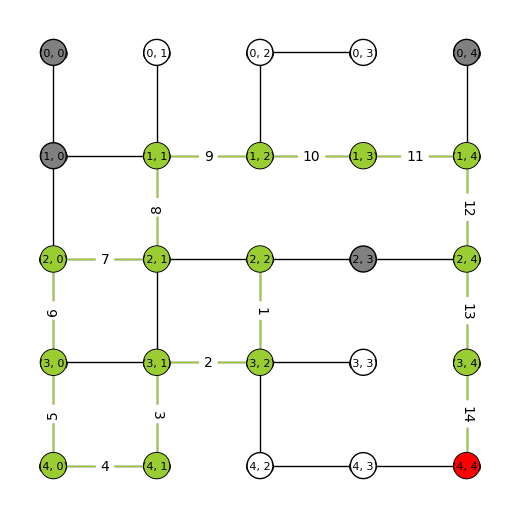

[(2, 2),
 (3, 2),
 (3, 1),
 (4, 1),
 (4, 0),
 (3, 0),
 (2, 0),
 (2, 1),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 4),
 (3, 4),
 (4, 4)]

In [18]:
road = setup_road(n_edges_to_remove=10)
agent = Agent(road)

agent.drive((2, 2), (4, 4))